<a href="https://colab.research.google.com/github/kdemertzis/Hydroinformatics/blob/main/04_uncertainty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Uncertainty quantification

In this notebook it is shown how to compute the uncertainty of the model simulation using the built-in uncertainty quantification options of Pastas. 

- Confidence interval of simulation
- Prediction interval of simulation
- Confidence interval of step response
- Confidence interval of block response
- Confidence interval of contribution
- Custom confidence intervals

The compute the confidence intervals, parameters sets are drawn from a multivariate normal distribution based on the jacobian matrix obtained during parameter optimization. This method to quantify uncertainties has some underlying assumptions on the model residuals (or noise) that should be checked. This notebook only deals with parameter uncertainties and not with model structure uncertainties.

In [1]:
!pip install pastas

     |████████████████████████████████| 104 kB 6.6 MB/s 


In [2]:
import pandas as pd
import pastas as ps

import matplotlib.pyplot as plt

ps.set_log_level("ERROR")
ps.show_versions()

Python version: 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]
Numpy version: 1.19.5
Scipy version: 1.4.1
Pandas version: 1.1.5
Pastas version: 0.18.0
Matplotlib version: 3.2.2


## Create a model

We first create a toy model to simulate the groundwater levels in southeastern Austria. We will use this model to illustrate how the different methods for uncertainty quantification can be used.  

In [3]:
gwl = pd.read_csv("https://raw.githubusercontent.com/kdemertzis/Hydroinformatics/main/data/head_wagna.csv", index_col=0, parse_dates=True, 
                  squeeze=True, skiprows=2).loc["2006":].iloc[0::10]
evap = pd.read_csv("https://raw.githubusercontent.com/kdemertzis/Hydroinformatics/main/data/evap_wagna.csv", index_col=0, parse_dates=True, 
                   squeeze=True, skiprows=2)
prec = pd.read_csv("https://raw.githubusercontent.com/kdemertzis/Hydroinformatics/main/data/rain_wagna.csv", index_col=0, parse_dates=True, 
                   squeeze=True, skiprows=2)

# Model settings
tmin = pd.Timestamp("2007-01-01") # Needs warmup
tmax = pd.Timestamp("2016-12-31")

ml = ps.Model(gwl)
sm = ps.RechargeModel(prec, evap, recharge=ps.rch.FlexModel(), 
                      rfunc=ps.Exponential, name="rch")
ml.add_stressmodel(sm)

# Add the ARMA(1,1) noise model and solve the Pastas model
ml.add_noisemodel(ps.ArmaModel())
ml.solve(tmin=tmin, tmax=tmax, noise=True)

Fit report GWL                        Fit Statistics
nfev    33                     EVP           74.70
nobs    365                    R2             0.75
noise   True                   RMSE           0.19
tmin    2007-01-01 00:00:00    AIC        -2051.35
tmax    2016-12-31 00:00:00    BIC        -2020.16
freq    D                      Obj            0.63
warmup  3650 days 00:00:00     ___                
solver  LeastSquares           Interp.          No

Parameters (8 optimized)
                optimal    stderr     initial   vary
rch_A          0.524959    ±9.95%    0.687428   True
rch_a         63.841819   ±13.21%   10.000000   True
rch_srmax    440.274070   ±42.57%  250.000000   True
rch_lp         0.250000     ±nan%    0.250000  False
rch_ks       917.340450  ±212.57%  100.000000   True
rch_gamma      4.934337   ±20.85%    4.000000   True
rch_simax      2.000000     ±nan%    2.000000  False
rch_kv         1.000000     ±nan%    1.000000  False
constant_d   262.644021    ±0.03%  2

/usr/local/lib/python3.7/dist-packages/pastas/model.py:1658: RuntimeWarning: invalid value encountered in log10
  atol = np.min([1e-8, 10**(np.round(np.log10(pmin)) - 1)])


## Diagnostic Checks

Before we perform the uncertainty quantification, we should check if the underlying statistical assumptions are met. We refer to the notebook on Diagnostic checking for more details on this.

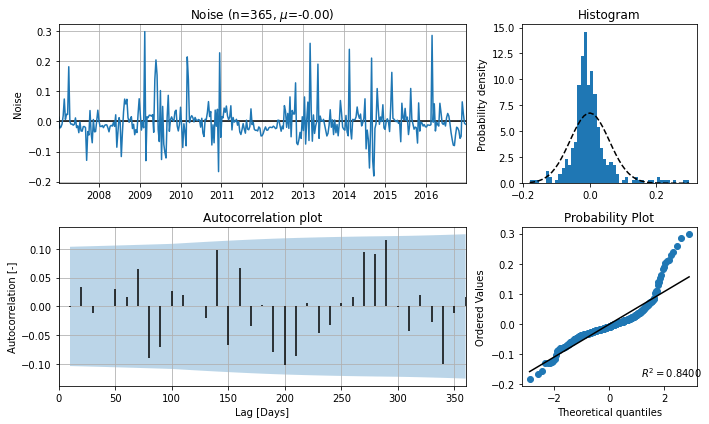

In [4]:
ml.plots.diagnostics();

## Confidence intervals

After the model is calibrated, a `fit` attribute is added to the Pastas `Model` object (`ml.fit`). This object contains information about the optimizations (e.g., the jacobian matrix) and a number of methods that can be used to quantify uncertainties.

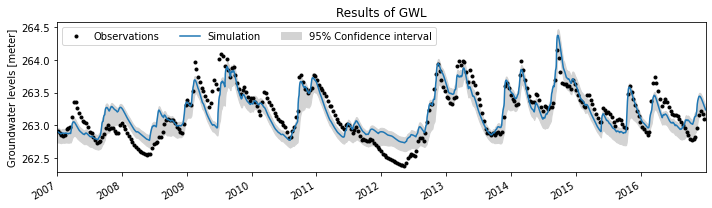

In [5]:
ci = ml.fit.ci_simulation(alpha=0.05, n=1000)
ax = ml.plot(figsize=(10,3));
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="lightgray")
ax.legend(["Observations", "Simulation", "95% Confidence interval"], ncol=3, loc=2)

## Prediction interval

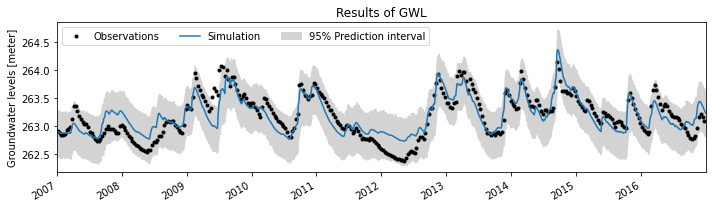

In [6]:
ci = ml.fit.prediction_interval(n=1000)
ax = ml.plot(figsize=(10,3));
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="lightgray")
ax.legend(["Observations", "Simulation", "95% Prediction interval"], ncol=3, loc=2)

## Uncertainty of step response 

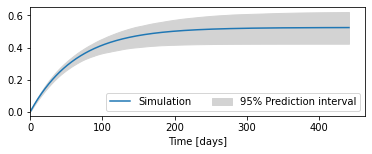

In [7]:
ci = ml.fit.ci_step_response("rch")
ax = ml.plots.step_response(figsize=(6,2))
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="lightgray")
ax.legend(["Simulation", "95% Prediction interval"], ncol=3, loc=4)

## Uncertainty of block response

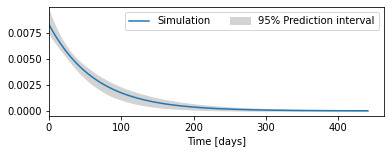

In [8]:
ci = ml.fit.ci_block_response("rch")
ax = ml.plots.block_response(figsize=(6,2))
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="lightgray")
ax.legend(["Simulation", "95% Prediction interval"], ncol=3, loc=1)

## Uncertainty of the contributions

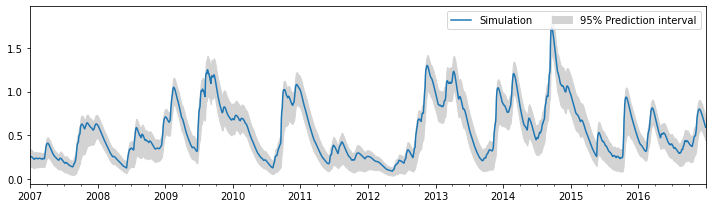

In [9]:
ci = ml.fit.ci_contribution("rch")
r = ml.get_contribution("rch")
ax = r.plot(figsize=(10,3))
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color="lightgray")
ax.legend(["Simulation", "95% Prediction interval"], ncol=3, loc=1)
plt.tight_layout()

## Custom Confidence intervals
It is also possible to compute the confidence intervals manually, for example to estimate the uncertainty in the recharge or statistics (e.g., SGI, NSE). We can call `ml.fit.get_parameter_sample` to obtain random parameter samples from a multivariate normal distribution using the optimal parameters and the covariance matrix. Next, we use the parameter sets to obtain multiple simulations of 'something', here the recharge.

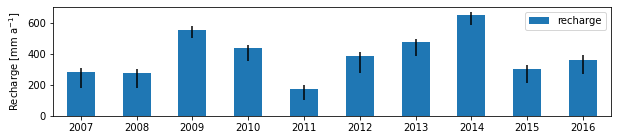

In [10]:
params = ml.fit.get_parameter_sample(n=1000, name="rch")
data = {}

# Here we run the model n times with different parameter samples
for i, param in enumerate(params):
    data[i] = ml.stressmodels["rch"].get_stress(p=param)

df = pd.DataFrame.from_dict(data, orient="columns").loc[tmin:tmax].resample("A").sum()
ci = df.quantile([0.025, .975], axis=1).transpose()

r = ml.get_stress("rch").resample("A").sum()
ax = r.plot.bar(figsize=(10,2), width=0.5, yerr=[r-ci.iloc[:,0], ci.iloc[:,1]-r])
ax.set_xticklabels(labels=r.index.year, rotation=0, ha='center')
ax.set_ylabel("Recharge [mm a$^{-1}$]")
ax.legend(ncol=3);

## Uncertainty of the NSE
The code pattern shown above can be used for many types of uncertainty analyses. Another example is provided below, where we compute the uncertainty of the Nash-Sutcliffe efficacy.

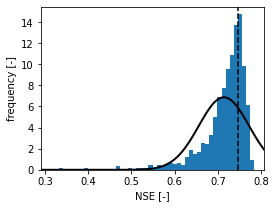

In [11]:
params = ml.fit.get_parameter_sample(n=1000)
data = []

# Here we run the model n times with different parameter samples
for i, param in enumerate(params):
    sim = ml.simulate(p=param)
    data.append(ps.stats.nse(obs=ml.observations(), sim=sim))

fig, ax = plt.subplots(1,1, figsize=(4,3))
plt.hist(data, bins=50, density=True)
ax.axvline(ml.stats.nse(), linestyle="--", color="k")
ax.set_xlabel("NSE [-]")
ax.set_ylabel("frequency [-]")

from scipy.stats import norm
import numpy as np

mu, std = norm.fit(data)

# Plot the PDF.
xmin, xmax = ax.set_xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
ax.plot(x, p, 'k', linewidth=2)